In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
#索引为0和2的独热向量示例
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [11]:
X=torch.arange(10).reshape((2,5))
F.one_hot(X.T,28).shape

torch.Size([5, 2, 28])

In [21]:
def get_params(vocab_size,num_hiddens,device):
    num_inputs=num_outputs=vocab_size

    def normal(shape):
        return torch.randn(size=shape,device=device)*0.01

    #隐藏层的参数
    W_xh=normal((num_inputs,num_hiddens))
    W_hh=normal((num_hiddens,num_hiddens))
    b_h=torch.zeros(num_hiddens,device=device)

    #输出层的参数
    W_out=normal((num_hiddens,num_outputs))
    b_out=torch.zeros(num_outputs,device=device)

    #附加梯度
    params=[W_xh,W_hh,W_out,b_h,b_out]
    for param in params :
        param.requires_grad_(True)
    return params

In [13]:
def init_rnn_state(batch_size,num_hiddens,device):
    return (torch.zeros((batch_size,num_hiddens),device=device),)

In [14]:
def rnn(inputs,state,params):
    #inputs的形状（时间步数，批量大小，词表大小）
    W_xh,W_hh,W_out,b_h,b_out=params
    H,=state
    outputs=[]

    for X in inputs:
        H=torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y=torch.mm(H,W_out)+b_out
        outputs.append(Y)
    
    return torch.cat(outputs,dim=0),(H,)

In [15]:
class RNNModuleScratch:
    def __init__(self,vocab_size,num_hiddens,device,get_params,init_state,forward_fn):
        self.vocab_size,self.num_hiddens=vocab_size,num_hiddens
        self.params=get_params(vocab_size,num_hiddens,device)
        self.init_state,self.forward_fn=init_state,forward_fn
    
    def __call__(self,X,state):
        X=F.one_hot(X.T,self.vocab_size).type(torch.float32)
        return self.forward_fn(X,state,self.params)
    
    def begin_state(self,batch_size,device):
        return self.init_state(batch_size,self.num_hiddens,device)

In [27]:
num_hiddens=512
net=RNNModuleScratch(len(vocab),num_hiddens,d2l.try_gpu(),get_params,init_rnn_state,rnn)
state=net.begin_state(X.shape[0],d2l.try_gpu())
Y,new_state=net(X.to(d2l.try_gpu()),state)
Y.shape,len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [28]:
def predict_ch8(prefix,num_preds,net,vocab,device):
    state=net.begin_state(batch_size=1,device=device)
    outputs=[vocab[prefix[0]]]
    get_input=lambda:torch.tensor([outputs[-1]],device=device).reshape((1,1))
    for y in prefix[1:]:
        _,state=net(get_input(),state)
        outputs.append(vocab[y])
    
    for _ in range(num_preds):
        y,state=net(get_input(),state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))

    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [31]:
predict_ch8('i hope zhouying being with me', 10, net, vocab, d2l.try_gpu())

'i hope zhouying being with meyibyomeyib'

In [43]:
#梯度裁减
def grad_clipping(net,theta):
    if isinstance(net,nn.Module):
        params=[p for p in net.parameters() if p.requires_grad]
    else:
        params=net.params
    
    norm=torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm>theta:
        for param in params:
            param.grad[:] *=theta/norm

In [44]:
def train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter):
    #先初始化state和timer
    state,timer=None,d2l.Timer()
    #记录训练损失之和，词元数量
    metric=d2l.Accumulator(2)

    for X,Y in train_iter:
        #下面这一整块都是判定进入一个新的batch的时候对state怎么进行初始化
        #第一次迭代或者使用随机抽样的情况是需要初始化state的
        if state is None or use_random_iter:
            state=net.begin_state(batch_size=X.shape[0],device=device)
        else:
            #模型是框架自带的模型并且状态不是元组
            if isinstance(net,nn.Module) and not isinstance(state,tuple):
                #将state从原本的计算图中隔开，使其只与本batch存在梯度的连接
                state.detach_()
            else:
                for s in state:
                    s.detach_()

        y=Y.T.reshape(-1)
        X,y=X.to(device),y.to(device)
        y_hat,state=net(X,state)
        l=loss(y_hat,y.long()).mean()
        if isinstance(updater,torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            updater(batch_size=1)
        
        metric.add(l*y.numel(),y.numel())
    
    return math.exp(metric[0]/metric[1]),metric[1]/timer.stop()

In [45]:
def train_ch8(net,train_iter,vocab,lr,num_epochs,device,use_random_iter=False):
    loss=nn.CrossEntropyLoss()
    animator=d2l.Animator(xlabel='epoch',ylabel='perplexity',legend=['train'],xlim=[10,num_epochs])

    if isinstance(net,nn.Module):
        updater=torch.optim.SGD(net.parameters(),lr)
    else:
        updater=lambda batch_size:d2l.sgd(net.params,lr,batch_size)
    
    predict=lambda prefix:predict_ch8(prefix,50,net,vocab,device)

    for epoch in range(num_epochs):
        ppl,speed=train_epoch_ch8(net,train_iter,loss,updater,device,use_random_iter)
        if(epoch+1)%10==0:
            print(predict('if i could be mature,i would not lose zhouying'))
            animator.add(epoch+1,[ppl])
    
    print(f'困惑度{ppl:.1f},{speed:.1f} 词元/秒 {str(device)}')
    print(predict('if i could be mature,i would not lose zhouying'))
    print(predict('could you come back'))


困惑度1.0,12747.9 词元/秒 cpu
if i could be mature<unk>i would not lose zhouying thit peat wiou have tlet you of nghwo it e for en
could you come back at is peat alout thin oubacaster acaleer cis lodi


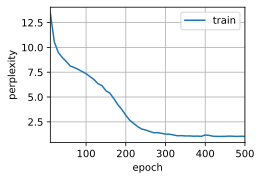

In [46]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度1.4,11594.9 词元/秒 cpu
if i could be mature<unk>i would not lose zhouying so surection at right angles to the others but so
could you come back on the atare have areal existencethere i object s


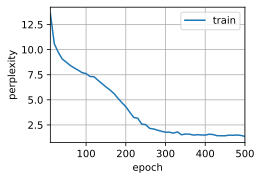

In [50]:
net = RNNModuleScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)